<a href="https://colab.research.google.com/github/jianfeiZhao/BI_projs/blob/master/finatech_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Thinking 1: 对于P2P租车场景，相似车型的划分有：按品牌划分（价格）；按车型大小、座位数划分（紧凑型、舒适型、SUV）；按用途划分（商务、旅游、婚庆）；按车子种类划分（新能源、普通、某特殊风格轿车）；按车子使用时长划分（新车、使用1-3年、使用3-5年、使用五年以上）。

### 搜索排序：

1. embedding划分

 User embedding: 用户历史偏好.
 
 User type embedding: 用户类别，用户信用。

 Host embedding: 车主信用、车主偏好。

 Car embedding: 车型划分。

2. 根据与用户的距离推荐距离较近的车主（地区embedding）

3. 计算embedded features：用户过去两周内点击过的Listing id
；用户点击并且停留在listing详情页超过60s；用户添加到Wish List中的Listing id；用户联系了但是没有预定；两周内用户预定的。


Action 1:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# load data
data = pd.read_csv('./UCI_Credit_Card.csv')
print(data.shape)
data.head()

(30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


0    23364
1     6636
Name: default.payment.next.month, dtype: int64


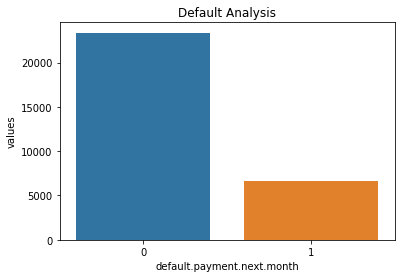

In [3]:
# show default next month
next_month = data['default.payment.next.month'].value_counts()
print(next_month)
df = pd.DataFrame({'default.payment.next.month': next_month.index, 'values': next_month.values})
plt.title('Default Analysis')
sns.barplot(x='default.payment.next.month', y='values', data=df)
plt.show()

In [4]:
data.drop(['ID'], axis=1, inplace=True)
target = data['default.payment.next.month'].values  # extract target for pred
columns = data.columns.to_list()
columns.remove('default.payment.next.month')
features = data[columns].values  # extract features using to pred

from sklearn.model_selection import train_test_split, GridSearchCV
# dataset split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3)

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# build multiple classifier
classifiers = [
       SVC(),
       DecisionTreeClassifier(),
       RandomForestClassifier(),
       KNeighborsClassifier()
]
classifier_names = [
       'svc', 'decisiontreeclassifier', 'randomforestclassifier', 'kneighborsclassifier'           
]
# 分类器参数
classifier_param_grid = [
            {'svc__C':[1], 'svc__gamma':[0.01]},
            {'decisiontreeclassifier__max_depth':[6,9,11]},
            {'randomforestclassifier__n_estimators':[3,5,6]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,8]},
]

def GridSearchCV_work(pipeline, train_x, train_y, test_x, test_y, model_param_grid, score = 'accuracy'):
  gridsearch = GridSearchCV(estimator=pipeline, param_grid=model_param_grid, scoring=score)
  # find the optimal params
  search = gridsearch.fit(train_x, train_y)
  y_pred = gridsearch.predict(test_x)
  print('GridSearch optimal params:', search.best_params_)
  print('GridSearch optimal score:', search.best_score_)
  print('Accuracy %0.4lf' %accuracy_score(test_y, y_pred))

import pickle
for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):
    pipeline = Pipeline([
            ('scaler', StandardScaler()),
            (model_name, model)
    ])
    #pickle.dump(pipeline, 'pipeline.pkl')   # store pipeline
    #pipeline = pickle.load('pipeline.pkl')  # load pipeline directly next time
    result = GridSearchCV_work(pipeline, X_train, y_train, X_test, y_test, model_param_grid, score = 'accuracy')


GridSearch optimal params: {'svc__C': 1, 'svc__gamma': 0.01}
GridSearch optimal score: 0.817
Accuracy 0.8151
GridSearch optimal params: {'decisiontreeclassifier__max_depth': 6}
GridSearch optimal score: 0.8179047619047619
Accuracy 0.8187
GridSearch optimal params: {'randomforestclassifier__n_estimators': 6}
GridSearch optimal score: 0.7988571428571428
Accuracy 0.7994
GridSearch optimal params: {'kneighborsclassifier__n_neighbors': 8}
GridSearch optimal score: 0.8043809523809523
Accuracy 0.8040


Action 2:

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('./creditcard.csv')
print(data.shape)
data.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


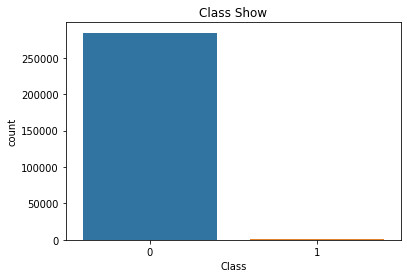

In [15]:
import itertools

# 显示误差矩阵
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues) :
    plt.figure()
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 0)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])) :
        plt.text(j, i, cm[i, j],
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# plot class distribution
sns.countplot(x='Class', data=data)
plt.title('Class Show')
plt.show()

In [16]:
# count fraud number
num = len(data)
num_fraud = len(data[data['Class']==1])
print('总交易数：', num)
print('欺诈交易数：', num_fraud)
print('欺诈交易数占比：{:.4f}'.format(num_fraud/num))

总交易数： 284807
欺诈交易数： 492
欺诈交易数占比：0.0017


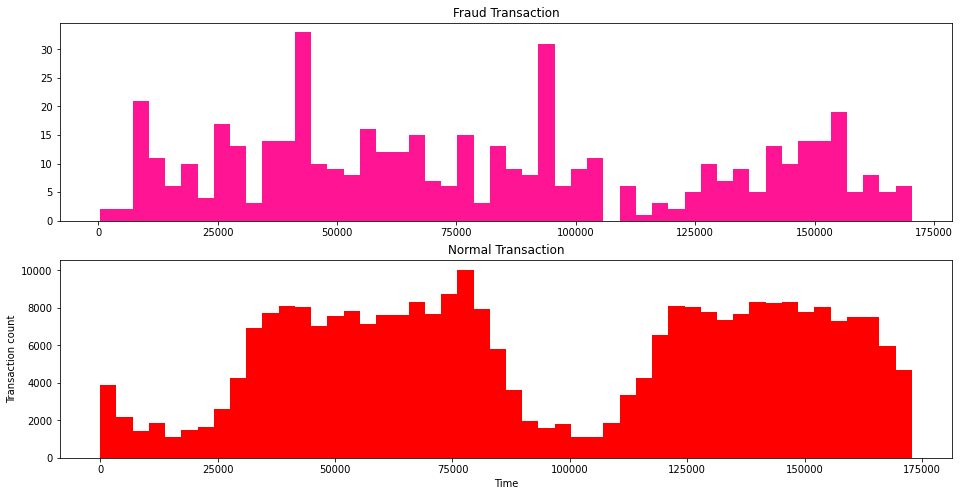

In [17]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(16,8))
ax1.hist(data.Time[data.Class==1], bins=50, color='deeppink')
ax1.set_title('Fraud Transaction')
ax2.hist(data.Time[data.Class==0], bins=50, color='red')
ax2.set_title('Normal Transaction')
plt.xlabel('Time')
plt.ylabel('Transaction count')
plt.show()

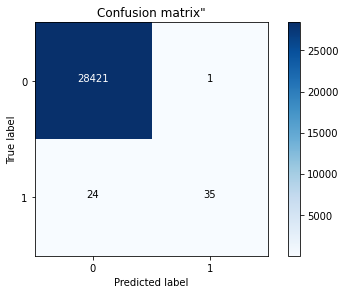

In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score

data['Amount_norm'] = StandardScaler().fit_transform(data['Amount'].values.reshape(-1,1))

# label
y = np.array(data.Class.to_list())
data = data.drop(['Time', 'Amount', 'Class'], axis=1)

# train test split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.1)

# model
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# confusion matrix
cm = confusion_matrix(y_test, y_pred)
classes = [0,1]
plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix"', cmap = plt.cm.Blues)


Precision:0.972
Recall:0.593
F1 Score:0.737


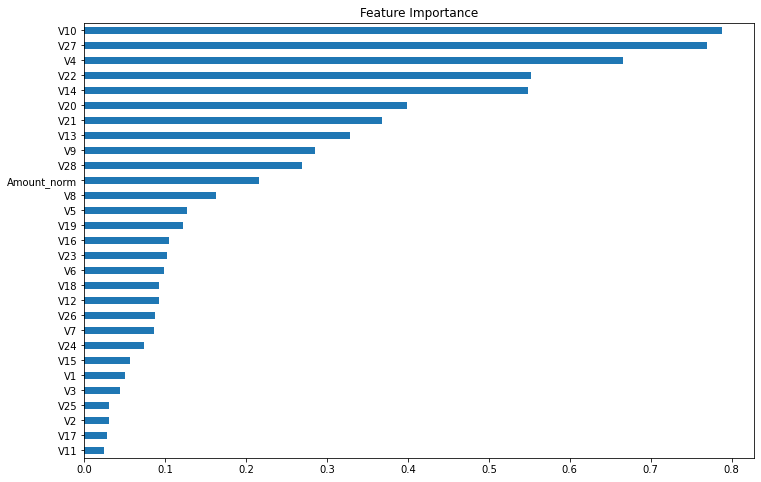

In [21]:
# 计算模型评估分数
def show_metrics():
  tp, fn, fp, tn = cm[1,1], cm[1,0], cm[0,1], cm[0,0]
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  print('Precision:{:.3f}'.format(precision))
  print('Recall:{:.3f}'.format(recall))
  print('F1 Score:{:.3f}'.format(2*precision*recall/(precision+recall)))

show_metrics()  

# 显示模型中特征重要性
coeffs = clf.coef_
df_co = pd.DataFrame(np.transpose(abs(coeffs)), columns=["coef_"])
# 下标设置为Feature Name
df_co.index = data.columns
df_co.sort_values("coef_", ascending=True, inplace=True)
plt.figure(figsize=(12,8))
df_co.coef_.plot(kind="barh")
plt.title("Feature Importance")
plt.show()